<a href="https://colab.research.google.com/github/spadrejuan/ml-final-project/blob/Nat-Branch2/Nat-ResNet50%20copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### For Google Colab to import Google Drive

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Convert JPG to JPEG

In [87]:
import cv2
import os
from pathlib import Path

# # For VSC
# DATA_DIR = "dataset/AI Art vs Real Art/" # Put unzipped files to the unzipped folder and change accordingly

# For Google Colab
DATA_DIR = "drive/MyDrive/dataset/AI Art vs Real Art/" # Put unzipped files to the unzipped folder and change accordingly

def jpg_to_jpeg(data_dir):
    for dir_name in os.listdir(data_dir):
        files = os.path.join(data_dir,dir_name)
        for filepaths in os.listdir(files):
            file_names = os.path.join(files,filepaths)
            if file_names.endswith(".jpg") or file_names.endswith(".JPG"):
                img = cv2.imread(str(file_names))
                cv2.imwrite(file_names[0:-4]+".jpeg", img)
                os.remove(file_names)

In [88]:
import imghdr

IMAGE_EXTENSIONS = [".png", ".jpg", ".jpeg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(DATA_DIR).rglob("*"):
    if filepath.suffix.lower() in IMAGE_EXTENSIONS:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

# Import Tensorflow and Keras

In [89]:
import tensorflow as tf
import keras

BATCH_SIZE = 64
HEIGHT = 256
WIDTH = 256
IMAGE_SIZE = (HEIGHT, WIDTH)

# Preprocessing

In [90]:
def load_dataset(path):
    all_files = [os.path.join(path, f) for f in os.listdir(path)]
    valid_files = [f for f in all_files if f.split('.')[-1].lower() in img_type_accepted_by_tf]
    return tf.data.Dataset.from_tensor_slices(valid_files)

def split_dataset(dataset, train_size, val_size):
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    return train_dataset, val_dataset

def undersample_dataset(dataset, target_size):
    return dataset.take(target_size)

def load_and_preprocess_image(file_path):
    file_extension = tf.strings.split(file_path, '.')[-1]
    image = tf.io.read_file(file_path)

    # Decode based on the file extension
    if file_extension == 'png':
        image = tf.image.decode_png(image, channels=3)
    elif file_extension == 'bmp':
        image = tf.image.decode_bmp(image, channels=3)
    elif file_extension == 'gif':
        image = tf.image.decode_gif(image)
        image = tf.squeeze(image, axis=0)  # Extract the first frame
    else:  # Default to JPEG
        image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    return image

def label_dataset(dataset, label):
    return dataset.map(lambda x: (x, label))

In [91]:
# AI_ART_PATH = 'dataset/AI Art vs Real Art/AI Art/AiArtData'
# REAL_ART_PATH = 'dataset/AI Art vs Real Art/Real/RealArt'
AI_ART_PATH = '/content/drive/MyDrive/dataset/AI Art vs Real Art/AI Art/AiArtData'
REAL_ART_PATH = '/content/drive/MyDrive/dataset/AI Art vs Real Art/Real/RealArt'
ai_images = load_dataset(AI_ART_PATH)
real_images = load_dataset(REAL_ART_PATH)

ai_dataset = ai_images.shuffle(buffer_size=1000, seed=1337)
real_dataset = real_images.shuffle(buffer_size=1000, seed=1337)

In [92]:
num_of_ai = len(os.listdir(AI_ART_PATH))
num_of_real = len(os.listdir(REAL_ART_PATH))
print(f'Total Number of Images: {num_of_ai + num_of_real} \nNumber of AI: {num_of_ai} \nNumber of Real: {num_of_real}')

ai_train_size = int(num_of_ai * 0.8) # 0.8 split
ai_val_size = num_of_ai - ai_train_size

real_train_size = int(num_of_real * 0.8)
real_val_size = num_of_real - real_train_size

Total Number of Images: 916 
Number of AI: 506 
Number of Real: 410


In [93]:
ai_train_dataset, ai_val_dataset = split_dataset(ai_dataset, ai_train_size, ai_val_size)
real_train_dataset, real_val_dataset = split_dataset(real_dataset, real_train_size, real_val_size)

target_train_size = min(ai_train_size, real_train_size)
target_val_size = min(ai_val_size, real_val_size)

print(f'Target Sizes of Training: {target_train_size} for Train, and {target_val_size} for Validation')

Target Sizes of Training: 328 for Train, and 82 for Validation


In [94]:
ai_train_dataset = undersample_dataset(ai_train_dataset, target_train_size)
real_train_dataset = undersample_dataset(real_train_dataset, target_train_size)

ai_val_dataset = undersample_dataset(ai_val_dataset, target_val_size)
real_val_dataset = undersample_dataset(real_val_dataset, target_val_size)

In [95]:
ai_train_dataset= ai_train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
real_train_dataset = real_train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ai_val_dataset =ai_val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
real_val_dataset = real_val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [96]:
ai_train_dataset = label_dataset(ai_train_dataset, 0)
real_train_dataset = label_dataset(real_train_dataset, 1)

ai_val_dataset = label_dataset(ai_val_dataset, 0)
real_val_dataset = label_dataset(real_val_dataset, 1)

In [97]:
train_dataset = ai_train_dataset.concatenate(real_train_dataset)
train_dataset = train_dataset.shuffle(buffer_size=1000)

val_dataset = ai_val_dataset.concatenate(real_val_dataset)
val_dataset = val_dataset.shuffle(buffer_size=1000)

In [98]:
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Display sample images

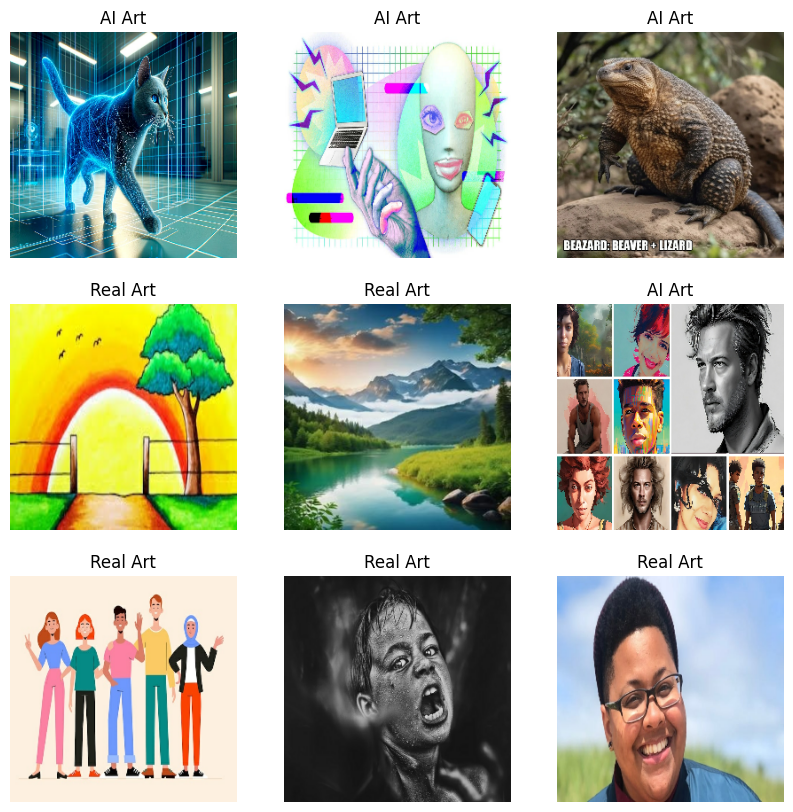

In [99]:
import matplotlib.pyplot as plt

def display_binary_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[int(labels[i].numpy())])
            plt.axis("off")

class_names = ['AI Art', 'Real Art']

display_binary_images(train_dataset, class_names)

In [100]:
from tensorflow import data as tf_data

train_dataset = train_dataset.prefetch(tf_data.AUTOTUNE).cache()
val_dataset = val_dataset.prefetch(tf_data.AUTOTUNE).cache()


## Base Model

In [101]:
import tensorflow as tf

# Load the ResNet50 model pre-trained on ImageNet data
base_model = tf.keras.applications.ResNet50(input_shape=(HEIGHT, WIDTH, 3), include_top=False, weights='imagenet')

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Combine the base model with the custom classification head
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower learning rate for fine-tuning
              loss='binary_crossentropy',
              metrics=[keras.metrics.BinaryAccuracy()])




In [102]:
EPOCHS = 10  # Number of epochs for training

In [103]:
from sklearn.metrics import f1_score

class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        # Extract validation data from the dataset
        x_val = []
        y_val = []
        for batch in self.validation_data:
            x, y = batch
            x_val.append(x)
            y_val.append(y)

        x_val = tf.concat(x_val, axis=0)
        y_val = tf.concat(y_val, axis=0)

        y_pred = self.model.predict(x_val)
        y_pred = tf.round(y_pred)  # Threshold for classification problems

        # Ensure both y_val and y_pred are of the same type
        y_val = tf.cast(y_val, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Calculate metrics
        tp = tf.reduce_sum(tf.cast(y_val * y_pred, 'float'), axis=0)
        fp = tf.reduce_sum(tf.cast((1 - y_val) * y_pred, 'float'), axis=0)
        fn = tf.reduce_sum(tf.cast(y_val * (1 - y_pred), 'float'), axis=0)

        precision = tp / (tp + fp + keras.backend.epsilon())
        recall = tp / (tp + fn + keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + keras.backend.epsilon())
        f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

        # Print metrics (optional)
        print(f'F1 Score on Validation Set at Epoch {epoch + 1}: {f1.numpy().mean():.4f}')
        print(f'True Positives: {tp.numpy().mean():.0f}')
        print(f'False Positives: {fp.numpy().mean():.0f}')
        print(f'False Negatives: {fn.numpy().mean():.0f}')
        print(f'Precision: {precision.numpy().mean():.4f}')
        print(f'Recall: {recall.numpy().mean():.4f}')

In [104]:
# Define Learning Rate Scheduling callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.2,           # Factor by which the learning rate will be reduced
    patience=3,           # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1             # Print message when learning rate is reduced
)

# Define Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Print message when training is stopped
    restore_best_weights=True  # Restore model weights to the point of best validation loss
)

f1_callback = F1ScoreCallback(val_dataset)

callbacks=[lr_scheduler, early_stopping, f1_callback]


In [105]:
# Train the model
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    callbacks=callbacks
                    )


Epoch 1/10
6/6 [==============================] - 5s 301ms/step
F1 Score on Validation Set at Epoch 1: 0.2641
True Positives: 29
False Positives: 30
False Negatives: 52
Precision: 0.4969
Recall: 0.1799
11/11 [==============================] - 28s 1s/step - loss: 0.6393 - binary_accuracy: 0.6357 - val_loss: 0.5631 - val_binary_accuracy: 0.7301 - lr: 1.0000e-04
Epoch 2/10
6/6 [==============================] - 1s 111ms/step
F1 Score on Validation Set at Epoch 2: 0.3484
True Positives: 44
False Positives: 44
False Negatives: 37
Precision: 0.4969
Recall: 0.2683
11/11 [==============================] - 5s 432ms/step - loss: 0.4914 - binary_accuracy: 0.7896 - val_loss: 0.4832 - val_binary_accuracy: 0.8098 - lr: 1.0000e-04
Epoch 3/10
6/6 [==============================] - 1s 112ms/step
F1 Score on Validation Set at Epoch 3: 0.3406
True Positives: 42
False Positives: 43
False Negatives: 39
Precision: 0.4969
Recall: 0.2591
11/11 [==============================] - 4s 384ms/step - loss: 0.4004 - 

## Fine-Tuning 1

In [106]:
# Unfreeze specific layers in the base model
# Here, we unfreeze the convolutional blocks corresponding to 'conv2' and 'conv4'
for layer in base_model.layers:
    if layer.name.startswith('conv2') or layer.name.startswith('conv4'):
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(1e-6),  # Very low learning rate
              loss='binary_crossentropy',
              metrics=[keras.metrics.BinaryAccuracy()])

In [107]:
# Train the model
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    callbacks=callbacks
                    )

Epoch 1/10
6/6 [==============================] - 1s 111ms/step
F1 Score on Validation Set at Epoch 1: 0.3380
True Positives: 42
False Positives: 42
False Negatives: 39
Precision: 0.4969
Recall: 0.2561
11/11 [==============================] - 28s 940ms/step - loss: 0.3118 - binary_accuracy: 0.8582 - val_loss: 0.1827 - val_binary_accuracy: 0.9325 - lr: 1.0000e-06
Epoch 2/10
6/6 [==============================] - 1s 114ms/step
F1 Score on Validation Set at Epoch 2: 0.3353
True Positives: 41
False Positives: 42
False Negatives: 40
Precision: 0.4969
Recall: 0.2530
11/11 [==============================] - 9s 806ms/step - loss: 0.2863 - binary_accuracy: 0.8796 - val_loss: 0.1886 - val_binary_accuracy: 0.9387 - lr: 1.0000e-06
Epoch 3/10
6/6 [==============================] - 1s 113ms/step
F1 Score on Validation Set at Epoch 3: 0.3299
True Positives: 40
False Positives: 41
False Negatives: 41
Precision: 0.4969
Recall: 0.2469
11/11 [==============================] - 8s 739ms/step - loss: 0.2680

## Fine-Tuning 2

In [108]:
# Unfreeze specific layers in the base model
# Here, we unfreeze the middle, and last convolutional blocks
for layer in base_model.layers:
    if layer.name.startswith('conv3') or layer.name.startswith('conv5'):
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(1e-6),  # Very low learning rate
              loss='binary_crossentropy',
              metrics=[keras.metrics.BinaryAccuracy()])

In [109]:
# Train the model
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    callbacks=callbacks
                    )

Epoch 1/10
6/6 [==============================] - 1s 110ms/step
F1 Score on Validation Set at Epoch 1: 0.3353
True Positives: 41
False Positives: 42
False Negatives: 40
Precision: 0.4969
Recall: 0.2530
11/11 [==============================] - 26s 816ms/step - loss: 0.3300 - binary_accuracy: 0.8613 - val_loss: 0.1853 - val_binary_accuracy: 0.9387 - lr: 1.0000e-06
Epoch 2/10
6/6 [==============================] - 1s 111ms/step
F1 Score on Validation Set at Epoch 2: 0.3326
True Positives: 41
False Positives: 41
False Negatives: 40
Precision: 0.4969
Recall: 0.2500
11/11 [==============================] - 7s 612ms/step - loss: 0.2979 - binary_accuracy: 0.8780 - val_loss: 0.1893 - val_binary_accuracy: 0.9448 - lr: 1.0000e-06
Epoch 3/10
6/6 [==============================] - 1s 111ms/step
F1 Score on Validation Set at Epoch 3: 0.3299
True Positives: 40
False Positives: 41
False Negatives: 41
Precision: 0.4969
Recall: 0.2469
11/11 [==============================] - 7s 609ms/step - loss: 0.2749

## Fine-Tuning 3

In [110]:
# Unfreeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-6),  # Very low learning rate
              loss='binary_crossentropy',
              metrics=[keras.metrics.BinaryAccuracy()])

In [111]:
# Train the model
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    callbacks=callbacks
                    )

Epoch 1/10
6/6 [==============================] - 2s 111ms/step
F1 Score on Validation Set at Epoch 1: 0.3326
True Positives: 41
False Positives: 41
False Negatives: 40
Precision: 0.4969
Recall: 0.2500
11/11 [==============================] - 41s 1s/step - loss: 0.3305 - binary_accuracy: 0.8537 - val_loss: 0.1893 - val_binary_accuracy: 0.9448 - lr: 1.0000e-06
Epoch 2/10
6/6 [==============================] - 1s 114ms/step
F1 Score on Validation Set at Epoch 2: 0.3299
True Positives: 40
False Positives: 41
False Negatives: 41
Precision: 0.4969
Recall: 0.2469
11/11 [==============================] - 9s 837ms/step - loss: 0.2929 - binary_accuracy: 0.8872 - val_loss: 0.1962 - val_binary_accuracy: 0.9387 - lr: 1.0000e-06
Epoch 3/10
6/6 [==============================] - 1s 116ms/step
F1 Score on Validation Set at Epoch 3: 0.3299
True Positives: 40
False Positives: 41
False Negatives: 41
Precision: 0.4969
Recall: 0.2469
11/11 [==============================] - 10s 917ms/step - loss: 0.2674 -